In [263]:
import numpy as np
import os
import sys
from tqdm import tqdm_notebook
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from skimage.transform import rescale, resize


from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
import tensorflow as tf
from skimage.io import imread
import torch

In [210]:
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import Dataset

In [4]:
from sklearn.model_selection import train_test_split

# My first fastai run on image segmentation task

In this notebook I run my first fastai model. I participate in a competition https://www.kaggle.com/c/tgs-salt-identification-challenge

The idea here is to identofy the segment of an image with the salt. Also, for every image the depth of the signals is provided. <br>
In the current solution I don't use the depth, but it is a definetely an important feature. To be done in future. 

Useful notebooks: 
    
https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

https://www.kaggle.com/bguberfain/unet-with-depth

I'm using the U-net architecture, where the encoder part is done with the pretrained model ResNet34. 

In [26]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [27]:
sz = 128
bs = 64 #batch size
nw = 16

In [322]:
PATH = Path('data/')
TRAIN_PATH = PATH/'train'

MASKS_FN = Path('train.csv')

TRAIN_DN = 'images'
MASKS_DN = 'masks'
TEST_PATH = 'test'

In [37]:
masks_csv = pd.read_csv(PATH/MASKS_FN)

In [39]:
masks_csv.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [137]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [62]:
x_names = np.array([str(Path(TRAIN_DN)/o) + '.png' for o in masks_csv['id']])
y_names = np.array([str(Path(MASKS_DN)/o) + '.png' for o in masks_csv['id']])

In [330]:
test_path_full = f'{TRAIN_PATH}/{TEST_PATH}'

In [336]:
x_test_names = np.array([f'{str(TEST_PATH)}/{o}' for o in os.listdir(test_path_full)])

In [66]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [67]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [343]:
trn_x

array(['images/e7ee2c6dce.png', 'images/64e79513a3.png', 'images/0a0814464f.png', ...,
       'images/1306fcee4c.png', 'images/48d81e93d9.png', 'images/edf1e6ac00.png'], dtype='<U21')

In [345]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)

datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=(x_test_names, x_test_names), path=TRAIN_PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [72]:
x,y = next(iter(md.trn_dl))

In [73]:
# example of one batch 

x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

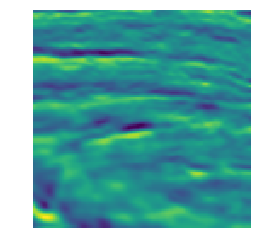

In [78]:
show_img(x[1, 0])

In [80]:
f = resnet34
cut, lr_cut = model_meta[f]

In [ ]:
def mean_iou(targs, pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (pred>t).float()
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [81]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [82]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [83]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [84]:
m_base = get_base()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/alperovich/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:20<00:00, 4239182.17it/s]


In [85]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [89]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5),dice]

In [90]:
learn.freeze_to(1)

 87%|████████▋ | 41/47 [06:52<01:00, 10.05s/it, loss=4.26]

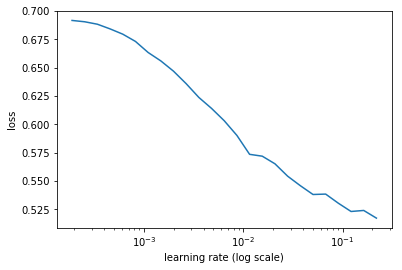

In [91]:
learn.lr_find()
learn.sched.plot()

In [92]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [103]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.353079   0.297378   0.904282   0.760175  
    1      0.270646   0.205787   0.921916   0.83337   
    2      0.233173   0.18541    0.920809   0.837806  
    3      0.202961   0.170233   0.925364   0.849966  


[array([0.17023]), 0.9253640553307911, 0.8499657885031255]

In [104]:
learn.save('tmp')

In [105]:
learn.load('tmp')


In [107]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs, 1, cycle_len=2,use_clr=(20,8))

In [110]:
learn.save('128')

In [111]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

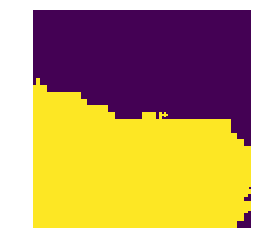

In [117]:
show_img(py[20]>0);

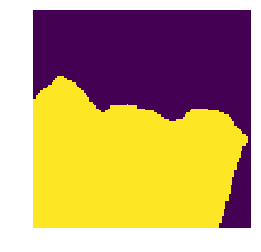

In [118]:
show_img(y[20]);

In [352]:
# Additional to the original test/validation images, apply image augmentation to them
# (just like for training images) and calculate the mean of predictions. The intent
# is to increase the accuracy of predictions by examining the images using multiple
# perspectives.

preds, y = learn.TTA(is_test=True)

In [374]:
preds_test = preds[0,:,:,:]

In [378]:
preds_val = learn.predict(is_test=False)

In [380]:
preds_val.shape

(1008, 128, 128)

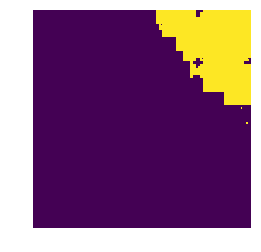

In [386]:
show_img(preds[4,2,:,:] > 1)

In [391]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

1008

In [423]:
def process_arr(x_img):
    return resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

In [425]:
val_true = np.array([process_arr(learn.data.val_ds.get_y(i)) for i in range(learn.data.val_dl.dataset.get_n())])

In [428]:
val_true = val_true[:,:,:,0]

In [429]:
val_true.shape

(1008, 128, 128)

In [430]:
preds_val.shape

(1008, 128, 128)

In [431]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(val_true, np.int32(preds_val > threshold)) for threshold in tqdm_notebook(thresholds)])

In [432]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

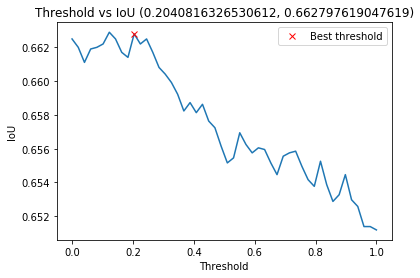

In [433]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [434]:
iou_best

0.662797619047619

In [435]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [437]:
preds_test.shape

(18000, 128, 128)

In [440]:
len(preds_test)

18000

In [455]:
preds_test[0,:,:]

array([[-2.4883 , -2.48298, -2.4331 , ..., -2.66538, -2.63582, -2.63114],
       [-2.46841, -2.45575, -2.40249, ..., -2.63596, -2.6078 , -2.60636],
       [-2.44443, -2.43607, -2.40244, ..., -2.59205, -2.59121, -2.59725],
       ...,
       [-0.97769, -0.9566 , -0.85019, ..., -2.97689, -2.97217, -2.96872],
       [-1.0464 , -1.02333, -0.9408 , ..., -2.98808, -3.00722, -3.01227],
       [-1.03787, -1.02742, -0.93785, ..., -2.97464, -2.98059, -2.98854]], dtype=float32)

In [438]:
def downsample(img):
    return resize(img, (101, 101), mode='constant', preserve_range=True)

In [448]:
fnames = [fname[5:-4] for fname in learn.data.test_ds.fnames]

In [451]:
pred_dict = {name: RLenc(np.round(downsample(preds_test[i, :, :]) > threshold_best)) for name, i in zip(fnames, range(len(preds_test)))}

In [457]:
pred_dict.get('dc066ad24e')

'39 11 140 12 241 12 342 12 443 12 544 12'

In [453]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('fastai_submission.csv')